In [2]:
# %pip install pandas
# %pip install seaborn
# %pip install bayesian-optimization
# %pip install matplotlib
# %pip install -U scikit-learn
# %pip install shap
# %pip install xgboost
# %pip install scikit-optimize


  Using cached PyYAML-6.0.1-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ------------------------------------- -- 102.4/107.8 kB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 107.8/107.8 kB 3.1 MB/s eta 0:00:00
Using cached PyYAML-6.0.1-cp311-cp311-win_amd64.whl (144 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
from skopt import BayesSearchCV
import shap


d:\projects\Machine_learning\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:

# Step 1: Import Titanic dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)


In [29]:

# Data preprocessing
data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
data = pd.get_dummies(data, drop_first=False)
data = data.fillna(data.mean())


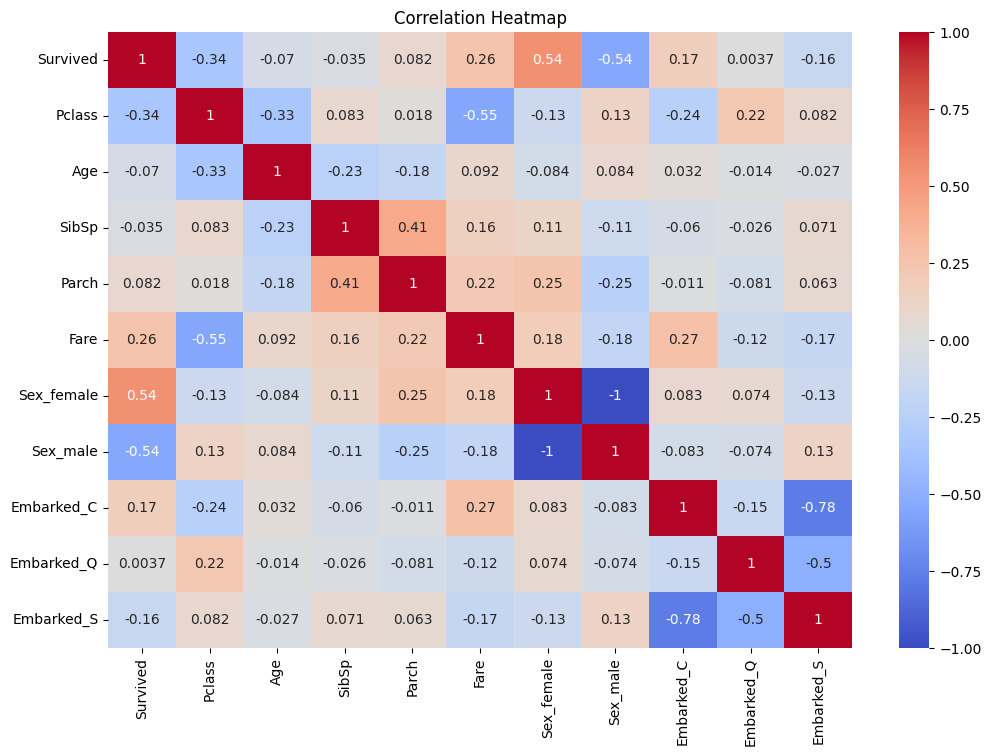

In [30]:

# Step 2: Correlation heat map plot
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [31]:

# Step 3: Descriptive analysis
data.describe()


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [32]:

# Step 4: Correlation of target with each feature
target = 'Survived'
correlations = data.corr()[target].sort_values(ascending=False)
print(correlations)


Survived      1.000000
Sex_female    0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.155660
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64


In [33]:

# Step 5: Train test split
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [34]:
# Step 6: XGBoost model training using Bayesian hyperparameter tuning
param_grid = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (50, 500),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}


In [35]:

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')



In [36]:
bayes_cv = BayesSearchCV(estimator=xgb_model, search_spaces=param_grid, n_iter=32, cv=3, n_jobs=-1, random_state=42)


In [38]:
bayes_cv.fit(X_train, y_train)



d:\projects\Machine_learning\.conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=32, n_jobs=-1, random_state=42,
              search_spaces={'colsample_bytree': (0.5, 1.0),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'subsample': (0.5, 1.0)})

In [39]:
# Best parameters
print("Best parameters found: ", bayes_cv.best_params_)

# Step 7: Check AUC, Classification report
best_model = bayes_cv.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]



Best parameters found:  OrderedDict([('colsample_bytree', 0.8732813581502332), ('learning_rate', 0.015452777022708135), ('max_depth', 3), ('n_estimators', 296), ('subsample', 0.8318788455598272)])


In [40]:
print("AUC: ", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))



AUC:  0.8882882882882883
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [41]:
# Step 8: Create SHAP values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)


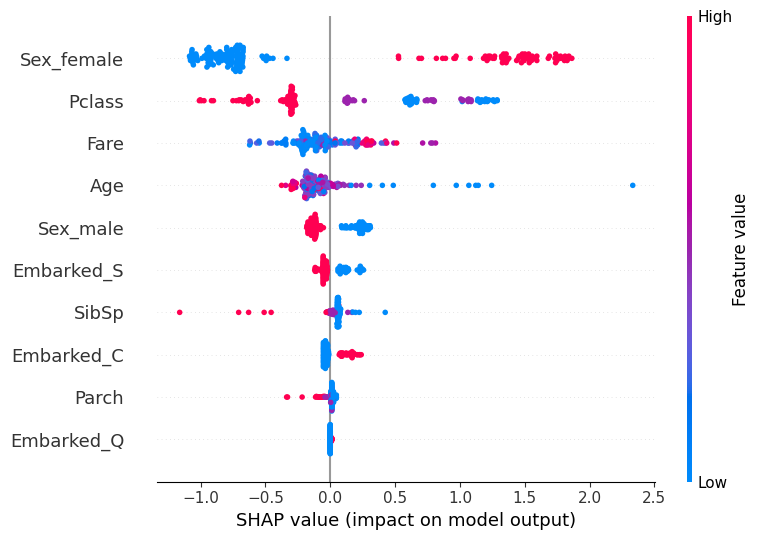

In [43]:

# Step 9: Explain SHAP values
shap.summary_plot(shap_values, X_test)


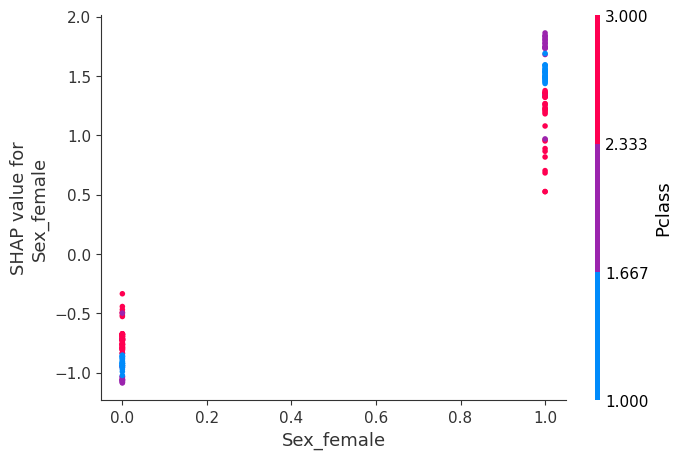

In [45]:
# shap.dependence_plot("Age", shap_values.values, X_test)
shap.dependence_plot("Sex_female", shap_values.values, X_test)